# **Kickstarter Success Prediction 🚀**

This Jupyter Notebook walks through the process of building a machine learning model to predict whether a Kickstarter campaign will be successful. We'll perform data loading, feature engineering, model training, and evaluation using a more granular, step-by-step approach.

---

## **1. Import Libraries**
First, we import the necessary Python libraries for data manipulation, visualization, and machine learning.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

---

## **2. Load Data**
Next, we load the Kickstarter dataset.

**Important:** Update the `file_path` variable to the location of your `kickstarter.csv` file.

In [18]:
# --- IMPORTANT: Update this file path to match your file's location ---
file_path = 'e:/ML_Project/kickstarter-success-prediction/data/kickstarter.csv'

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")

✅ Dataset loaded successfully!


---

## **3. Dataset Details & Initial Exploration**
Let's get a better understanding of our dataset. This dataset contains information on thousands of Kickstarter campaigns, each with various attributes like the project's category, funding goal, launch date, and final status.

Our goal is to use these attributes to predict the `binary_state` (successful or failed).

First, a quick preview of the data.

In [19]:
# Display the first few rows of the dataframe
df.head(3)

,Unnamed: 0,id,backers_count,blurb,currency,goal,launched_at,deadline,location.country,name,...,days_to_deadline,goal_USD,category_name,category_slug,blurb_length,location_type,location_country,location_state,location_displayable_name,binary_state
0,0,857125548,1,Exploring paint and its place in a digital world.,USD,2000.0,2015-03-19 22:34:57,2015-04-30 23:12:00,US,Remix,...,42,2000.0,Digital Art,art,9,Town,US,NY,"New York, NY",failed
1,1,1038659700,2,Mike Fassio wants a side-by-side photo of me a...,USD,10.0,2014-07-17 01:55:07,2014-07-27 01:55:07,US,Photo of Grant and Hazel eating cake with bare...,...,10,10.0,Digital Art,art,21,Town,US,WA,"Seattle, WA",failed
2,2,1238331911,0,I need your help to get a nice graphics tablet...,USD,900.0,2014-07-30 16:29:13,2014-08-29 16:29:13,US,Minecraft Digital Art/Animations,...,30,900.0,Digital Art,art,12,Town,US,VA,"Moneta, VA",failed


Now, let's look at the data types and check for missing values.

In [20]:
# Get a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430938 entries, 0 to 430937
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 430938 non-null  int64  
 1   id                         430938 non-null  int64  
 2   backers_count              430938 non-null  int64  
 3   blurb                      430936 non-null  object 
 4   currency                   430938 non-null  object 
 5   goal                       430938 non-null  float64
 6   launched_at                430938 non-null  object 
 7   deadline                   430938 non-null  object 
 8   location.country           429843 non-null  object 
 9   name                       430934 non-null  object 
 10  usd_pledged                430938 non-null  float64
 11  slug                       430938 non-null  object 
 12  spotlight                  430938 non-null  bool   
 13  staff_pick                 43

---

### **3.1. Data Visualization**
Now let's visualize some key aspects of our data. We'll look at the distribution of successful vs. failed projects and how key numerical features relate to each other.

C:\Users\Maruf Rana\AppData\Local\Temp\ipykernel_8400\1725446423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df, x='binary_state', palette='viridis')
C:\Users\Maruf Rana\AppData\Local\Temp\ipykernel_8400\1725446423.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Failed', 'Successful', 'Other']) # Added 'Other' for raw data


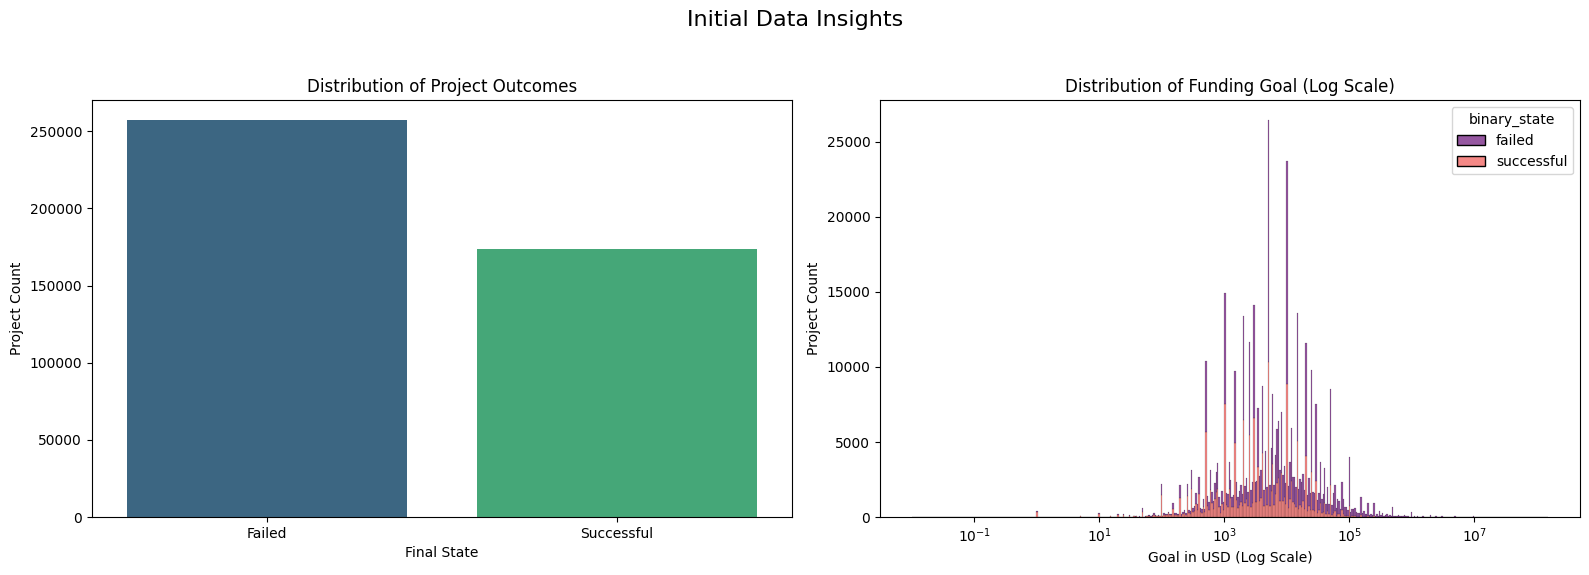

In [21]:
# Set up the figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Initial Data Insights', fontsize=16)

# 1. Distribution of Project Outcomes
# Use df instead of df_processed
sns.countplot(ax=axes[0], data=df, x='binary_state', palette='viridis') 
axes[0].set_title('Distribution of Project Outcomes')
axes[0].set_xticklabels(['Failed', 'Successful', 'Other']) # Added 'Other' for raw data
axes[0].set_xlabel('Final State')
axes[0].set_ylabel('Project Count')

# 2. Distribution of Funding Goal by Outcome
# Use df instead of df_processed
sns.histplot(ax=axes[1], data=df, x='goal_USD', hue='binary_state', multiple='stack', log_scale=True, palette='magma')
axes[1].set_title('Distribution of Funding Goal (Log Scale)')
axes[1].set_xlabel('Goal in USD (Log Scale)')
axes[1].set_ylabel('Project Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **4. Feature Engineering & Data Cleaning**
In this step, we'll clean the data and create new features to improve our model's performance.

### **4.1. Engineer New Features from Dates**
We start by making a copy of the dataframe to work on.

In [22]:
# Start with a clean copy to preserve the original dataframe
df_processed = df.copy()

Now, we convert the `launched_at` column to a datetime object, which is necessary to extract time-based features.

In [23]:
# Convert 'launched_at' to a datetime object
df_processed['launched_at'] = pd.to_datetime(df_processed['launched_at'])

From the datetime object, we create new features: the day of the week the campaign was launched and a flag for whether it was a weekend.

In [24]:
# Create new time-based features
df_processed['day_of_week'] = df_processed['launched_at'].dt.dayofweek # Monday=0, Sunday=6
df_processed['is_weekend'] = df_processed['day_of_week'].isin([5, 6]).astype(int)
print("✅ Engineered new features: 'day_of_week' and 'is_weekend'.")

✅ Engineered new features: 'day_of_week' and 'is_weekend'.


### **4.2. Clean and Prepare Target Variable**
We filter the dataset to include only projects that were clearly 'successful' or 'failed', removing other states like 'canceled' or 'live'.

In [25]:
# Filter for 'successful' and 'failed' projects
valid_states = ['successful', 'failed']
df_processed = df_processed[df_processed['binary_state'].isin(valid_states)]
print("✅ Filtered for valid states.")

✅ Filtered for valid states.


Next, we convert our target variable, `binary_state`, into a numeric format where `1` represents a successful project and `0` represents a failed one.

In [26]:
# Convert target variable to numeric
df_processed['binary_state'] = df_processed['binary_state'].map({'successful': 1, 'failed': 0})
print("✅ Target variable converted to numeric.")

✅ Target variable converted to numeric.


---

## **5. Prepare Data for Modeling**
Here, we select our features (`X`) and target (`y`) and split them for training and testing.

### **5.1. Define Features (X) and Target (y)**

First, we define our target variable `y`.

In [27]:
# Define the target variable
y = df_processed['binary_state']

Next, we specify columns to be removed. Some are "leaky" (containing information that isn't available at the time of prediction, like `backers_count`) and others are simply unnecessary for modeling.

In [28]:
# Define leaky and unnecessary columns
leaky_columns = ['usd_pledged', 'backers_count', 'spotlight', 'state']
unnecessary_columns = [
    'Unnamed: 0', 'id', 'blurb', 'name', 'currency', 'deadline', 'launched_at',
    'goal', 'category_slug', 'location.country', 'slug', 'location_displayable_name',
    'location_typelocation_country', 'location_statelocation_displayable_name'
]

Now, we create our feature set `X` by dropping the target and the specified unnecessary columns.

In [29]:
# Define features 'X' by dropping target and specified columns
X = df_processed.drop(columns=['binary_state'] + leaky_columns + unnecessary_columns, errors='ignore')

Finally, we convert all remaining categorical text features into numerical format using one-hot encoding.

In [30]:
# One-hot encode all remaining categorical features
X = pd.get_dummies(X, drop_first=True)
print(f"✅ Data prepared for modeling. Total features: {X.shape[1]}")

✅ Data prepared for modeling. Total features: 1734


### **5.2. Split Data**
We split the data into training (80%) and testing (20%) sets.

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Data split into training and testing sets.")

✅ Data split into training and testing sets.


---

## **6. Train and Evaluate the Model**
We will train a Random Forest Classifier. A key improvement here is using `class_weight='balanced'`, which helps the model handle imbalanced datasets.

### **6.1. Train the Random Forest Model**

Initialize the model with our chosen parameters.

In [32]:
# Initialize the model with our key improvement: class_weight='balanced'
rf_model_improved = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Addresses class imbalance
    random_state=42,
    n_jobs=-1
)

Now, fit the model to the training data.

In [33]:
# Fit the model on the training data
print("🌳 Training the Random Forest model...")
rf_model_improved.fit(X_train, y_train)
print("✅ Model training complete.")

🌳 Training the Random Forest model...
✅ Model training complete.


### **6.2. Evaluate Model Performance**
Make predictions on the unseen test data.

In [34]:
# Make predictions on the test set
y_pred_rf_imp = rf_model_improved.predict(X_test)
print("✅ Predictions made on the test set.")

✅ Predictions made on the test set.


Evaluate the model's accuracy.

In [35]:
# Print the accuracy score
print("\n--- Evaluation of Improved Random Forest Model ---")
print(f"Improved Model Accuracy: {accuracy_score(y_test, y_pred_rf_imp):.4f}")


--- Evaluation of Improved Random Forest Model ---
Improved Model Accuracy: 0.7802


Use a classification report for a more detailed performance breakdown, including precision, recall, and F1-score for each class.

In [36]:
# Print the full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_imp, target_names=['Failed', 'Successful']))


Classification Report:
              precision    recall  f1-score   support

      Failed       0.80      0.84      0.82     51397
  Successful       0.74      0.70      0.72     34791

    accuracy                           0.78     86188
   macro avg       0.77      0.77      0.77     86188
weighted avg       0.78      0.78      0.78     86188



### **6.3. ROC Curve Analysis**
The ROC (Receiver Operating Characteristic) curve and its corresponding AUC (Area Under the Curve) score provide a comprehensive view of the model's performance across all classification thresholds. An AUC closer to 1.0 indicates a better model.

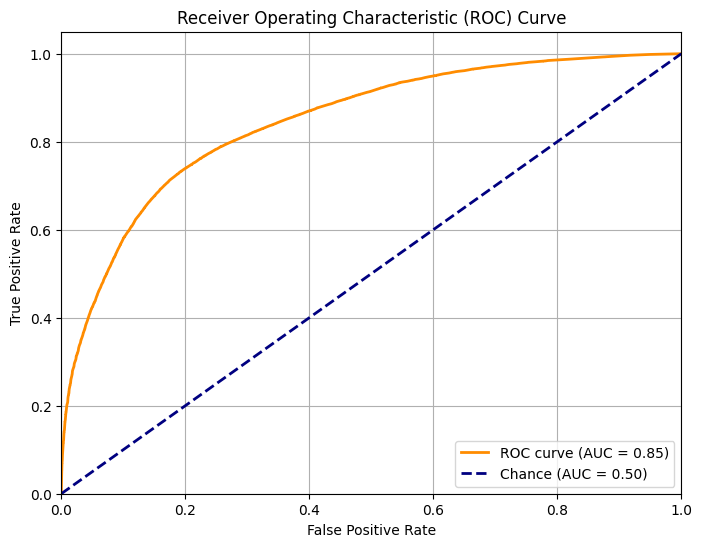

In [37]:
from sklearn.metrics import roc_curve, auc

# --- Prerequisite: Get predicted probabilities ---
# We need the probability of the 'successful' class (which is the second column)
y_pred_proba_rf_imp = rf_model_improved.predict_proba(X_test)[:, 1]

# Calculate ROC curve inputs
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf_imp)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

---

## **7. Analyze Feature Importance**
Finally, let's see which features the model found most important.

Get the feature importances from the trained model.

In [38]:
# Get feature importances and names from the trained model
importances = rf_model_improved.feature_importances_
feature_names = X_train.columns

Create a DataFrame to make the data easier to work with.

In [39]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

Sort the features by importance to find the most influential ones.

In [40]:
# Sort by importance and get the top 20 features
top_20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

Plot the top 20 features.

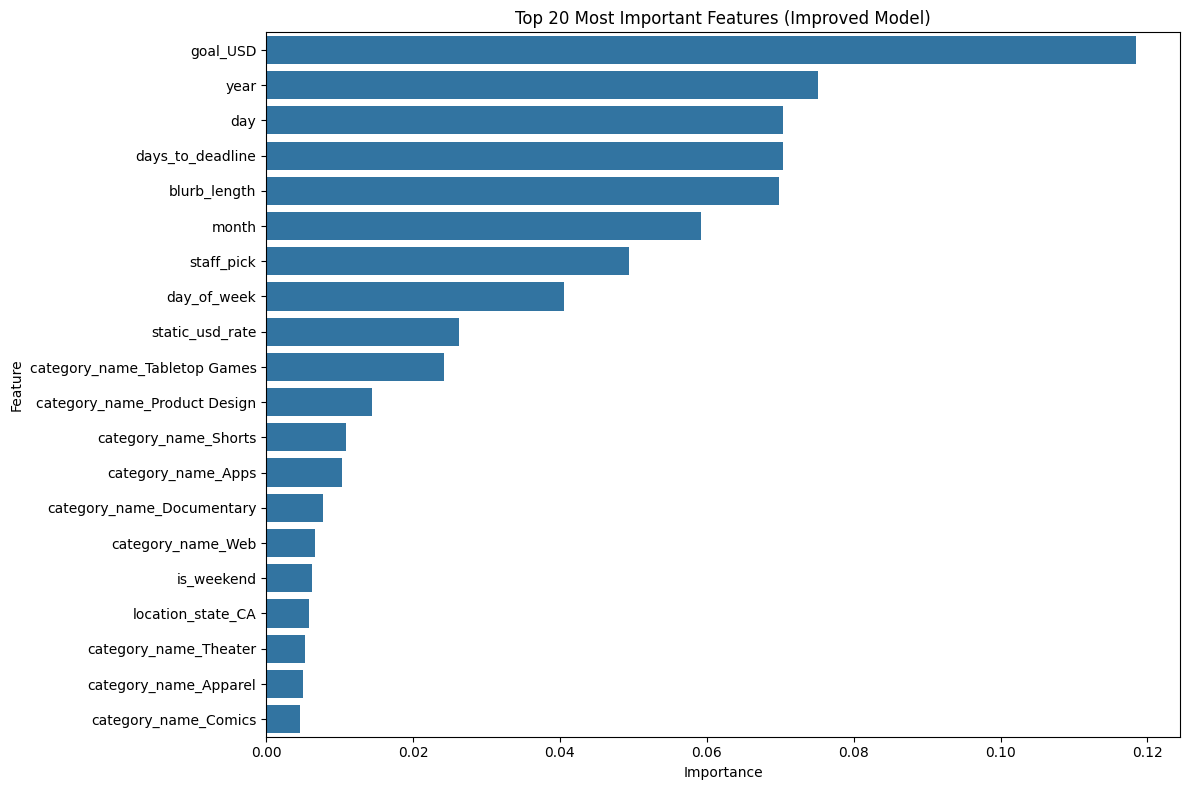

In [41]:
# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Most Important Features (Improved Model)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()